In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Duplicate key in file PosixPath('/Users/songye/opt/anaconda3/envs/aiffel2/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc'), line 263 ('font.family         : NanumSquareOTFRegular, Malgun Gothic, AppleGothic, Arial')


In [2]:
df= pd.read_csv("../dataset/240128_TripAdvisorHotelReviews/dataset_1K_removed_stopwords_ver.csv")

In [3]:
df['tokens'][0]

"['everyone', 'alby', 'made', 'reservation', 'deenny', 'greeted', 'every', 'morning', 'hailed', 'cabs', 'jennifer', 'front', 'desk', 'made', 'sure', 'stay', 'wonderful', 'already', 'rebooked', 'extended', 'stay', 'next', 'month', 'work', 'takes', 'back', 'thanks']"

In [4]:
##!! 저장을 해도 어차피 다시 list로 변환을 해주어야 한다. 

import pandas as pd
import ast

# 문자열을 파싱하여 리스트로 변환하는 함수
def parse_string_to_list(tokens_str):
    return ast.literal_eval(tokens_str)

# 모든 행에 대해 함수 적용
df['tokens'] = df['tokens'].apply(parse_string_to_list)



In [5]:
type(df['tokens'][0])

list

In [7]:
sentences = df['tokens']

In [8]:
from gensim.models import Word2Vec

# 토큰화된 문장으로 Word2Vec 모델 학습
model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)


In [9]:
# 단어 임베딩
embedding_dim = 300
embedded_sequences = [[model.wv[word] for word in sequence] for sequence in sentences]

In [10]:
print(type(embedded_sequences[0][0]))
print(embedded_sequences[0][0])


<class 'numpy.ndarray'>
[-0.01508767 -0.01375846  0.54336077  0.29996157  0.14792979 -0.17906967
 -0.14509666  0.6185202   0.54712325  0.10522348 -0.16947532 -0.1841349
 -0.3532048   0.559739   -0.41954842 -0.4118884  -0.00995278 -0.33158183
  0.07308264 -0.35744345 -0.04797698 -0.11047643  0.31495154 -0.25506705
 -0.10061631  0.32702857 -0.5008783   0.5390339  -0.22418447  0.07879049
 -0.14665422  0.5290773  -0.02810895  0.05751298 -0.66522866 -0.19291998
 -0.14582965 -0.25150162  0.3212738   0.0452955   0.08506062  0.05771056
  0.22014375 -0.52357066 -0.2883944  -0.08994217  0.00972305 -0.20713657
 -0.02928271  0.3771165   0.13477     0.14865005 -0.013643   -0.14797091
  0.44103548 -0.07102808 -0.16050455  0.2309603   0.35786358 -0.17361687
 -0.55841064 -0.47160435  0.07875775 -0.17842603 -0.27478337 -0.09541608
  0.4052839  -0.37409708 -0.7592906  -0.1708485  -0.13997012 -0.397104
  0.17938682 -0.581182   -0.17191112  0.15602258  0.06176503 -0.08719619
 -0.52005404 -0.22922538 -0.05

In [12]:
# 패딩 처리
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(embedded_sequences, padding='post', maxlen=200)

2024-02-16 20:00:01.304721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
len(padded_sequences[0][0])

#총 10000개의 데이터가 있고
#각 데이터는 200을 max length로 해서 맞춰 놓음. 
#그리고 각 단어별로는 300을 embedding 차원으로 정함. 

300

In [14]:
labels = df['ratings']
labels[0]

'high'

In [15]:
import numpy as np

# labels 배열
labels = np.array(labels)

# 값을 숫자로 변환하는 코드
labels = np.array([1 if value == 'high' else 0 for value in labels])

print("Modified labels:", labels)


Modified labels: [1 1 1 ... 0 0 0]


In [16]:
import numpy as np

# 넘파이 배열로 변환
embedded_sequences = np.array(padded_sequences)
labels = np.array(labels)


In [17]:
from sklearn.model_selection import train_test_split

# PyTorch DataLoader로 사용할 데이터셋 클래스를 정의하고 데이터를 생성하는 작업이 필요

# 예시: X는 embedded_sequence, y는 refined_df['ratings']
X_train, X_temp, y_train, y_temp = train_test_split(embedded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [49]:
type(X_train)

numpy.ndarray

In [18]:
# 결과 확인
print("Train data shapes:", X_train.shape, y_train.shape)
print("Validation data shapes:", X_val.shape, y_val.shape)
print("Test data shapes:", X_test.shape, y_test.shape)

Train data shapes: (7000, 200, 300) (7000,)
Validation data shapes: (1500, 200, 300) (1500,)
Test data shapes: (1500, 200, 300) (1500,)


## 딥러닝으로 학습시키기

In [21]:
import tensorflow as tf
# 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 모델 훈련하기 

In [38]:
# 모델 훈련
history =model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/300
110/110 [==============================] - 2s 13ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4887
Epoch 2/300
110/110 [==============================] - 1s 7ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4887
Epoch 3/300
110/110 [==============================] - 1s 7ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4887
Epoch 4/300
110/110 [==============================] - 1s 8ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4887
Epoch 5/300
110/110 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4887
Epoch 6/300
110/110 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6935 - val_accuracy: 0.4887
Epoch 7/300
110/110 [==============================] - 1s 7ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.488

## 모델 평가하기 

In [39]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss: {test_loss}')
print('Test Accuracy: {test_accuracy}')

47/47 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4887
Test Loss: {test_loss}
Test Accuracy: {test_accuracy}


## 정확도와 손실 그래프 그리기

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' 

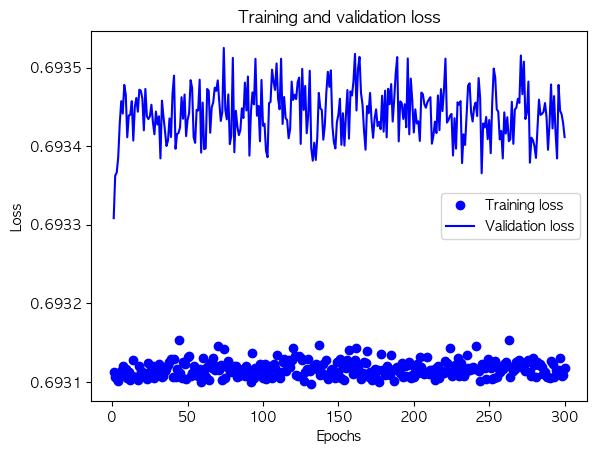

In [41]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'NanumSquareOTFRegular' 

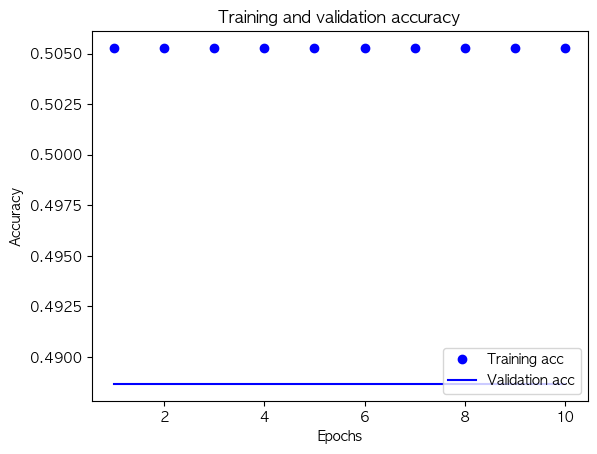

In [34]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## 새로운 데이터로 추론하기 

In [35]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

model.predict(examples)

ValueError: in user code:

    File "/Users/songye/opt/anaconda3/envs/aiffel2/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/songye/opt/anaconda3/envs/aiffel2/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/songye/opt/anaconda3/envs/aiffel2/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/songye/opt/anaconda3/envs/aiffel2/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/songye/opt/anaconda3/envs/aiffel2/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/songye/opt/anaconda3/envs/aiffel2/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "global_average_pooling1d_1" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None
